# Capítulo 3 - Clasificación

# Indice
- [Configuración](#Configuración)
- [MNIST](#MNIST)
- [Entrenando un clasificador binario](#Entrenando-un-clasificador-binario)
- [Medidas del rendimiento](#Medidas-del-rendimiento)
  - [Medición de la precisión mediante cross validation](#Medición-de-la-precisión-mediante-cross-validation)
  - [Matriz de confusión](#Matriz-de-confusión)
  - [Precisión y Sensibilidad](#Precisión-y-Sensibilidad)
  - [Compensación precisión/sensibilidad](#Compensación-precisión-vs-sensibilidad)
  - [La curva ROC](#La-curva-ROC)
- [Clasificación Multiclase](#Clasificación-Multiclase)
- [Análisis de error](#Análisis-de-error)
- [Clasificación Multilabel](#Clasificación-Multilabel)
- [Clasificación Multioutput](#Clasificación-Multisalida)
- [Material Extra](#Material-Extra)
 - [Clasificador dummy](#Clasificador-dummy)
 - [Clasificador KNN](#Clasificador-KNN)
- [Ejercicios](#Ejercicios)
 - [Ej.1 Un clasificador de MNIST con una precisión de más del 97%](#Ej.1-Un-clasificador-de-MNIST-con-una-precisión-de-más-del-97%)
 - [Ej.2 Data Augmentation](#Ej.2-Data-Augmentation)
 - [Ej.3 Aborda el dataset del *Titanic*](#Ej.3-Aborda-el-dataset-del-Titanic)
 - [Ej.4 Clasificador de spam](#Ej.4-Clasificador-de-spam)

# Configuración

In [1]:
# imports comunes
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Hacer las salidas de este notebook estables a través de ejecuciones
np.random.seed(42)

# Hacemos algunos ajustes a los gráficos
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Donde grabar las figuras
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "clasificacion"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Grabando figura", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

# Ignorar warning inútiles (ver SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

import dill

In [82]:
# dill.load_session("03_classification.env")

# MNIST

`fetch_mldata()` está en desuso desde Scikit-Learn 0.20. Deberemos usar `fetch_openml()` en su lugar. Sin embargo, devuelve el conjunto de datos MNIST sin clasificar, mientras que `fetch_mldata()` devuelve el conjunto de datos ordenado por objetivo (el conjunto de entrenamiento yde prueba se clasificaron por separado). En general, esto está bien, pero si deseamos obtener exactamente los mismos resultados que antes, debemos ordenar el conjunto de datos utilizando la siguiente función:

In [2]:
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

In [3]:
from sklearn.datasets import fetch_openml

In [4]:
mnist = fetch_openml('mnist_784', version=1, cache=True)
mnist.target = mnist.target.astype(np.int8) # fetch_openml() devuelve targets como cadenas
sort_by_target(mnist) # fetch_openml() devuelve un dataset sin ordenar
mnist["data"], mnist["target"]

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([0, 0, 0, ..., 9, 9, 9], dtype=int8))

Generalmente, los dataset cargados de Scikit-Learn tiene una estructura similar de diccionario, incluyendo:

+ una clave `DESCR` describiendo el dataset
+ una clave `data` conteniendo un array con una fila por cada instancia y una columna por cada característica
+ una clave `target` conteniendo un array con las etiquetas (objetivo)

In [5]:
mnist["data"].shape

(70000, 784)

In [6]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [7]:
y.shape

(70000,)

In [8]:
28*28

784

Es decir, 70.000 imágenes y 784 características. Esto es así porque cada imagen está son 28x28 pixels y cada característica representa un pixel de intensidad, de 0 (blanco) a 255 (negro). Echemos un vistazo a un dígito del conjunto de datos. Todo lo que necesitamos es tomar el vector de características de una instancia, cambiarlo a una matriz de 28 × 28 y mostrarlo usando la función `imshow()` de Matplotlib:

Grabando figura some_digit_plot


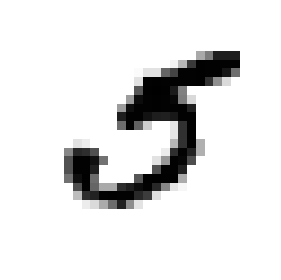

In [9]:
some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = mpl.cm.binary,
           interpolation="nearest")
plt.axis("off")

save_fig("some_digit_plot")
plt.show()

Parece un 5, veamos cuál es su etiqueta:

In [10]:
y[36000]

5

In [11]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [12]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Grabando figura more_digits_plot


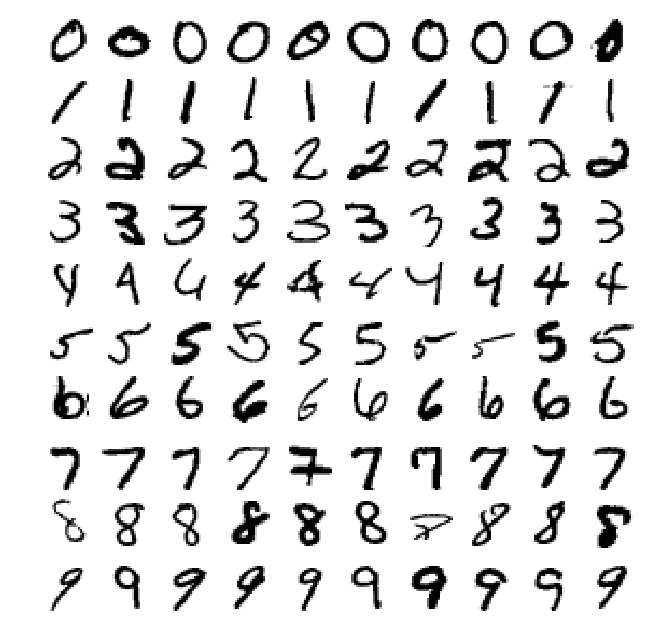

In [13]:
plt.figure(figsize=(9,9))
example_images = np.r_[X[:12000:600], X[13000:30600:600], X[30600:60000:590]]
plot_digits(example_images, images_per_row=10)
save_fig("more_digits_plot")
plt.show()

Siempre debemos crear un conjunto de pruebas y apartarlo antes de inspeccionar los datos de cerca. El conjunto de datos MNIST ya está dividido en un conjunto de entrenamiento (las primeras 60.000 imágenes) y un conjunto de prueba (las últimas 10.000 imágenes):

In [14]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Vamos a mezclar también el conjunto de entrenamiento; esto garantizará que todos los folds de validación cruzada sean similares (no querremos que falten algunos dígitos en un fold). Además, algunos algoritmos de aprendizaje son sensibles al orden de las instancias de entrenamiento y tienen un bajo rendimiento si obtienen muchas instancias similares seguidas. Al barajar el conjunto de datos se garantiza que esto no suceda:

In [15]:
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

# Entrenando un clasificador binario

Vamos a simplificar el problemas y vamos a tratar de detectar si un número es un 5 o no lo es (*clasificador binario*). Creemos los vectores objetivo de esta tarea de clasificación:

In [16]:
y_train_5 = (y_train == 5)  # True para todos los 5's, False para el resto de números
y_test_5 = (y_test == 5)

Bien, ahora vamos a elegir un clasificador y entrenarlo. Un buen lugar para comenzar es con un clasificador *Stochastic Gradient Descent* (SGD), utilizando la clase `SGDClassifier` de Scikit-Learn. Este clasificador tiene la ventaja de ser capaz de manejar conjuntos de datos muy grandes de manera eficiente. Esto se debe en parte a que SGD se ocupa de las instancias de capacitación de forma independiente, una a la vez (lo que también hace que la SGD sea adecuado para el aprendizaje en línea).

In [17]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5, tol=-np.infty, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=-inf,
       validation_fraction=0.1, verbose=0, warm_start=False)

Ahora puedes usarlo para detectar imágenes del número 5

In [18]:
sgd_clf.predict([some_digit])

array([ True])

# Medidas del rendimiento

## Medición de la precisión mediante cross validation

In [19]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy", n_jobs=-1, verbose=2)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.3s finished


array([0.9502 , 0.96565, 0.96495])

¿Más del 95% de precisión (relación de predicciones correctas) en todos los folds de validación cruzada? Esto es increíble, ¿no? Bueno, antes de que nos emocionemos demasiado pensemos en un clasificador muy tonto que simplemente clasifica cada imagen en la clase "no 5" y que devuelve True siempre. Tendría más del 90% de precisión. Esto se debe simplemente a que solo el 10% de las imágenes son 5, por lo que si siempre adivina que una imagen no es un 5, tendrá razón aproximadamente el 90% del tiempo. 

Esto demuestra por qué la precisión generalmente no es la medida de rendimiento preferida para los clasificadores, especialmente cuando se trata de conjuntos de datos sesgados (es decir, cuando algunas clases son mucho más frecuentes que otras).

## Matriz de confusión

Una forma mucho mejor de evaluar la ejecución de un clasificador es la *matriz de confusión*. La idea general es contar el número de veces que las instancias de la clase A son clasificadas como clase B. Antes de calcular la matriz de confusión necesitamos un conjunto de predicciones, para poder compararlas con los targets actuales. Para evitar tocar los datos de prueba utilizaremos la función `cross_val_predict()`.

In [20]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

Ahora ya estamos preparados para obtener la matriz de confusión usando `confusion_matrix()`:

In [21]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53272,  1307],
       [ 1077,  4344]], dtype=int64)

Cada fila en una matriz de confusión representa una *clase real*, mientras que cada columna representa una *clase predicha*. La primera fila de esta matriz considera imágenes no-5 (la clase negativa): 53.272 de ellas se clasificaron correctamente como no-5 (se llaman negativas verdaderas), mientras que las 1.307 restantes se clasificaron erróneamente como 5s (falsos positivos). La segunda fila considera las imágenes de 5s (la clase positiva): 1.077 se clasificaron erróneamente como no-5s (falsos negativos), mientras que los 4.344 restantes se clasificaron correctamente como 5s (verdaderos positivos). Un clasificador perfecto solo tendría verdaderos positivos y verdaderos negativos, por lo que su matriz de confusión tendría valores distintos de cero solo en su diagonal principal (arriba a la izquierda a la parte inferior derecha):

In [22]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

La matriz de confusión proporciona mucha información, pero a veces podemos preferir una métrica más concisa. Una interesante es la precisión de las predicciones positivas: esto se llama la *precisión* del clasificador.

precisión = TP / (TP + FP). Es decir, la precisión se calcula como True Positive dividido por la suma de True Positive más False Positive.

Una forma trivial de tener una precisión perfecta es hacer una sola predicción positiva y asegurarse de que sea correcta (precisión = 1/1 = 100%). Esto no sería muy útil ya que el clasificador ignoraría todas las instancias, excepto una positiva. Por lo tanto, la precisión se usa normalmente junto con otra métrica llamada *recall*, también llamada *sensibilidad* o *true positive ratio* (TPR): esta es la proporción de instancias positivas que el clasificador detecta correctamente.

recall = TP / (TP + FN), es decir, True Positive dividido por la suma de True Positive más False Negative.

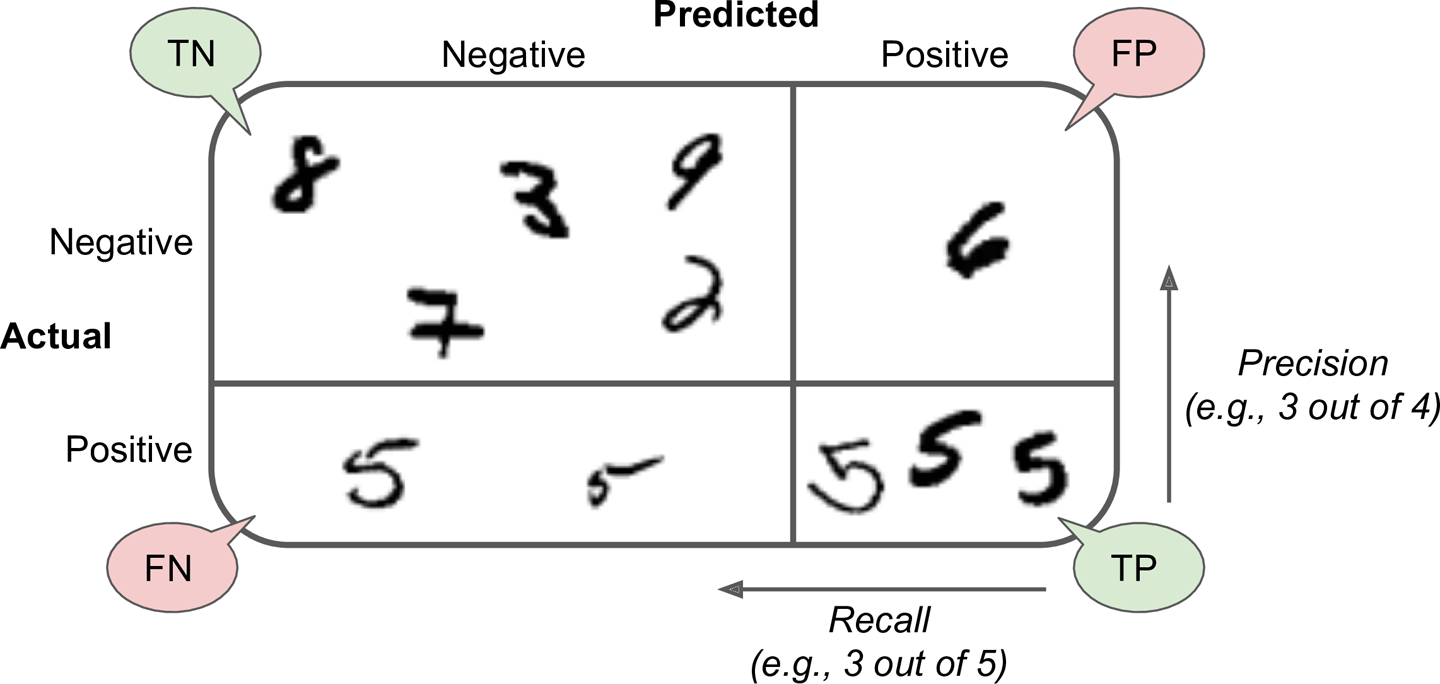

In [23]:
from IPython.display import Image
Image(filename=PROJECT_ROOT_DIR + "/images/clasificacion/confusion_matrix.png")

## Precisión y Sensibilidad

In [24]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.7687135020350381

Vamos a comprobar que es correcto de forma manual:

In [25]:
4344 / (4344 + 1307)

0.7687135020350381

In [26]:
recall_score(y_train_5, y_train_pred)

0.801328168234643

In [27]:
4344 / (4344 + 1077)

0.801328168234643

Parece que ahora nuestro detector de 5s no se ve tan brillante como lo hizo cuando calculamos su precisión. Cuando dice que una imagen representa un 5, es correcto solo el 77% de las veces. Además, solo detecta el 80% de los 5s.

A menudo es conveniente combinar precisión y recuperación en una sola métrica llamada puntuación F1 (*F1 score*), en particular si necesitamos una forma sencilla de comparar dos clasificadores. La puntuación de F1 es la *media armónica* de precisión y sensibilidad (ecuación 3-3). Mientras que la media regular trata a todos los valores por igual, la media armónica otorga mucho más peso a los valores bajos. Como resultado, el clasificador solo obtendrá una puntuación alta en F1 si tanto la sensibilidad como la precisión son altas.

In [28]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7846820809248555

In [29]:
4344 / (4344 + (1077 + 1307)/2)

0.7846820809248555

La puntuación de F1 favorece a los clasificadores que tienen una precisión y memoria similares. Esto no es siempre lo que queremos: en algunos contextos, nos importará la precisión y en otros contextos realmente nos importa recordar. Por ejemplo, si entrenamos a un clasificador para que detecte videos que son seguros para los niños, probablemente preferiremos un clasificador que rechace muchos videos buenos (recordatorios bajos) pero que mantenga solo los seguros (alta precisión), en lugar de un clasificador que tenga mucho mayor sensibilidad, pero que permita que algunos videos realmente malos se muestren en nuestro producto (en tales casos, es posible que deseemos agregar un control humano para verificar la selección de videos del clasificador). Por otro lado, supongamos que entrenamos a un clasificador para detectar ladrones en las imágenes de vigilancia: probablemente esté bien si su clasificador tiene solo un 30% de precisión, siempre que tenga un 99% de sensibilidad (seguro, los guardias de seguridad recibirán algunas alertas falsas, pero casi todos los ladrones serán atrapados).

Desafortunadamente, no podemos tenerlo de las dos maneras: aumentar la precisión reduce la sensibilidad, y viceversa. Esto se llama *compensación de precisión/sensibilidad*.

## Compensación precisión vs sensibilidad

Para entender este compromiso, veamos cómo `SGDCClassifier` toma sus decisiones de clasificación. Para cada instancia, calcula una puntuación basada en una función de decisión y si esa puntuación es mayor que un umbral, asigna la instancia a la clase positiva, o bien la asigna a la clase negativa. En la siguiente figura se muestran algunos dígitos ubicados desde la puntuación más baja de la izquierda hasta la puntuación más alta de la derecha. Supongamos que el umbral de decisión se ubica en la flecha central (entre los dos 5): encontrará 4 verdaderos positivos (5 reales) a la derecha de ese umbral, y un falso positivo (en realidad un 6). Por lo tanto, con ese umbral la precisión es del 80% (4 de 5). Pero de 6 reales 5, el clasificador solo detecta 4, por lo que la recuperación es del 67% (4 de 6). Ahora, si aumenta el umbral (muévalo a la flecha de la derecha), el falso positivo (el 6) se convierte en un verdadero negativo, lo que aumenta la precisión (hasta el 100% en este caso), pero un verdadero positivo se convierte en un falso negativo, disminuyendo la recuperación hasta el 50%. Por el contrario, bajar el umbral aumenta la recuperación y reduce la precisión.

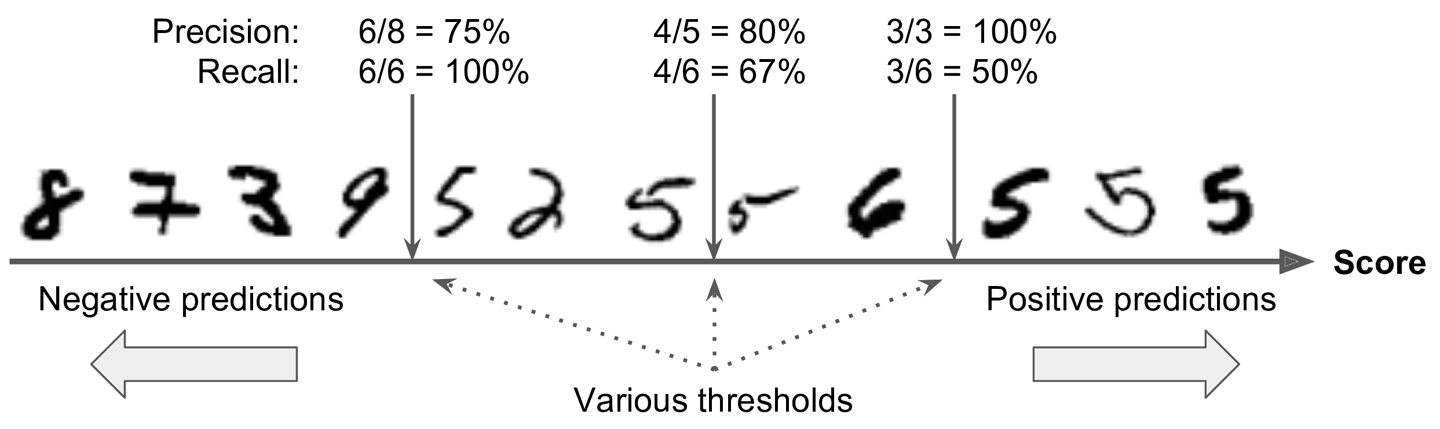

In [30]:
Image(filename=PROJECT_ROOT_DIR + "/images/clasificacion/decision_threshold.png")

Scikit-Learn no nos permite establecer el umbral directamente, pero nos da acceso a las puntuaciones de decisión que utiliza para hacer predicciones. En lugar de llamar al método `predict()` del clasificador, llamamos a su método `decision_function()`, que devuelve una puntuación para cada instancia y luego hacer predicciones basadas en esas puntuaciones utilizando cualquier umbral que deseemos:

In [31]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([161855.74572176])

In [32]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [33]:
y_some_digit_pred

array([ True])

`SGDClassifier` usa un umbral igual a 0, como vemos. Vamos a subir el umbral:

In [34]:
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

Esto confirma que elevar el umbral disminuye la sensibilidad. La imagen en realidad representa un 5 y el clasificador lo detecta cuando el umbral es 0, pero lo pierde cuando el umbral se incrementa a 200.000. Entonces, ¿cómo podemos decidir qué umbral usar? Para ello, primero deberemos obtener las puntuaciones de todas las instancias en el conjunto de entrenamiento utilizando la función `cross_val_predict()` nuevamente, pero esta vez especificando que desea que devuelva las puntuaciones de decisión en lugar de las predicciones:

In [35]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

Ahora, con estas puntuaciones podemos calcular la precisión y recuperar todos los umbrales posibles utilizando la función `precision_recall_curve()`:

In [36]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Grabando figura precision_recall_vs_threshold_plot


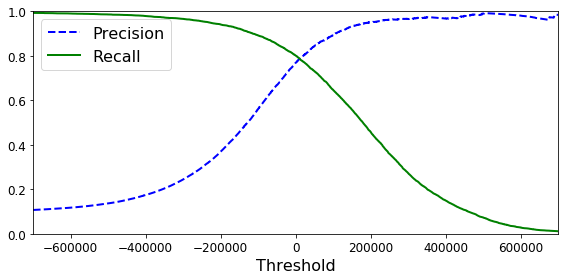

In [37]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000, 700000])
save_fig("precision_recall_vs_threshold_plot")
plt.show()

Ahora podemos simplemente seleccionar el valor de umbral que nos ofrezca la mejor compensación de precisión/sensibilidad para su tarea. 

Otra forma de seleccionar una buena precisión/sensibilidad es trazar la precisión directamente contra la sensibilidad:

Grabando figura precision_vs_recall_plot


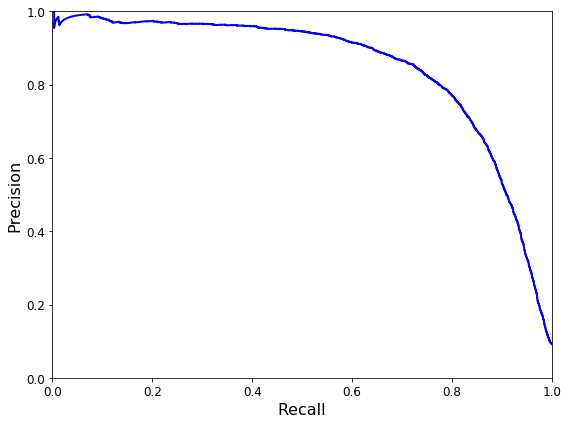

In [38]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
save_fig("precision_vs_recall_plot")
plt.show()

Se puede ver que la precisión realmente comienza a caer bruscamente en torno al 80% de sensibilidad. Es probable que queramos seleccionar una compensación de precisión/sensibilidad justo antes de esa caída, por ejemplo, en aproximadamente el 60% de sensibilidad. Pero, por supuesto, la elección depende de nuestro proyecto. Así que supongamos que decidimos apuntar a una precisión del 90%. Buscamos en el primer gráfico (acercando un poco el zoom) y descubrimos que necesitamos usar un umbral de aproximadamente 100.000. Para hacer predicciones (en el conjunto de entrenamiento por ahora), en lugar de llamar al método `predict()` del clasificador, podemos ejecutar este código:

In [39]:
(y_train_pred == (y_scores > 0)).all()

True

In [40]:
y_train_pred_90 = (y_scores > 100000)
precision_score(y_train_5, y_train_pred_90)

0.8935031847133758

In [41]:
recall_score(y_train_5, y_train_pred_90)

0.646928610957388

¡Genial, tenemos un clasificador de precisión del 90% (o lo suficientemente cerca)! Como vemos, es bastante fácil crear un clasificador con prácticamente cualquier precisión que desee: simplemente establezcamos un umbral lo suficientemente alto y listo. Hmm, no tan rápido. ¡Un clasificador de alta precisión no es muy útil si su sensibilidad es demasiado baja!

## La curva ROC

La curva ROC (*receiver operating characteristic*) es otra herramienta común que se utiliza con los clasificadores binarios. Es muy similar a la curva de precisión/sensibilidad, pero en lugar de trazar la precisión frente a la sensibilidad, la curva ROC traza el *ratio de verdaderos positivos* contra la *tasa de falsos positivos*. El FPR es el ratio de casos negativos que se clasifican incorrectamente como positivos. Es igual a uno menos la *tasa verdaderos negativos*, que es el ratio de casos negativas que se clasifican correctamente como negativos. El TNR también se llama *especificidad*. Por lo tanto, la curva ROC representa la *sensibilidad* (recall) versus 1 - *especificidad*.

In [42]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

Grabando figura roc_curve_plot


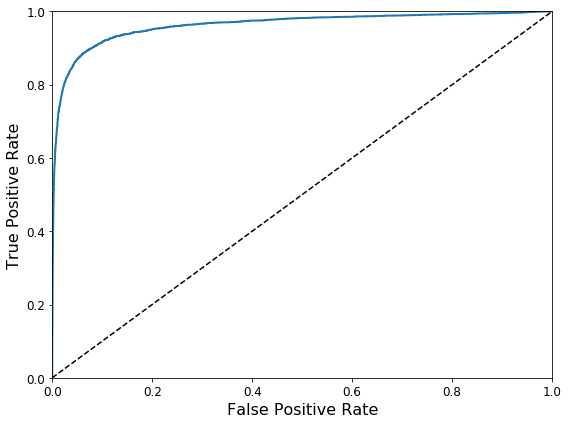

In [43]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
save_fig("roc_curve_plot")
plt.show()

Una vez más, hay una compensación: cuanto mayor sea la sensibilidad (TPR), más falsos positivos (FPR) el clasificador produce. La línea de puntos representa la curva ROC de un clasificador puramente aleatorio. Un buen clasificador se mantiene lo más alejado posible de esa línea (hacia la esquina superior izquierda).

Una forma de comparar los clasificadores es medir el *área bajo la curva* (AUC). Un clasificador perfecto tendrá una ROC AUC igual a 1, mientras que un clasificador puramente aleatorio tendrá una AUC ROC igual a 0.5.

In [44]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9624496555967156

Dado que la curva ROC es muy similar a la de precisión/sensibilidad (o PR), cabría preguntarnos ómo decidir cuál utilizar. Como regla general, deberíamos preferir la curva PR siempre que la clase positiva sea rara o cuando le interesen más los falsos positivos que los falsos negativos y la curva ROC al contrario. Por ejemplo, al observar la curva ROC anterior (y la puntuación AUC ROC), puede pensarse que el clasificador es realmente bueno. Pero esto se debe principalmente a que hay pocos positivos (5s) en comparación con los negativos (no 5s). En contraste, la curva PR deja claro que el clasificador tiene margen de mejora (la curva podría estar más cerca de la esquina derecha).

Vamos a entrenar un `RandomForestClassifier` y comparemos su curva ROC y la puntuación ROC AUC con el `SGDClassifier`. Primero, necesitamos obtener puntuaciones para cada instancia en el conjunto de entrenamiento. Pero debido a la forma en que funciona), la clase `RandomForestClassifier` no tiene un método de `decision_function()`. En su lugar, tiene un método `predict_proba()`. Los clasificadores de Scikit-Learn generalmente tienen uno u otro. El método `predict_proba()` devuelve una matriz que contiene una fila por instancia y una columna por clase, cada una conteniendo la probabilidad de que la instancia dada pertenezca a la clase dada (por ejemplo, 70% de probabilidad de que la imagen represente un 5):

In [45]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=10, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, n_jobs=-1, verbose=2, 
                                    method="predict_proba")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.2s finished


Pero para trazar una curva ROC necesitamos puntuaciones, no probabilidades. Una solución simple es usar la probabilidad de la clase positiva como puntuación:

In [46]:
y_scores_forest = y_probas_forest[:, 1] # score = probabilidad de la clase positivos
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

Es útil dibujar primero la curva ROC para ver cómo se comparan:

Grabando figura roc_curve_comparison_plot


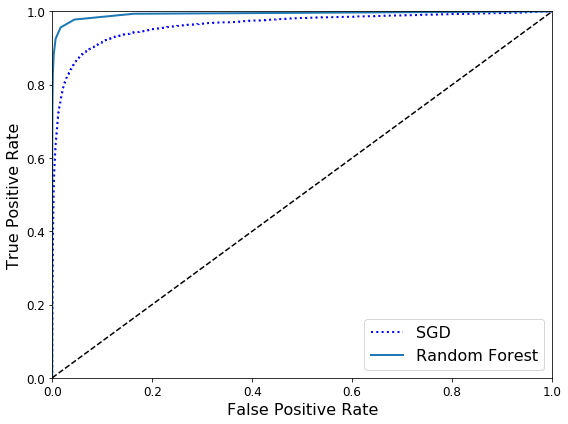

In [47]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right", fontsize=16)
save_fig("roc_curve_comparison_plot")
plt.show()

Como se puede ver la curva ROC de `RandomForestClassifier` es mucho mejor que la de `SGDClassifier`: está mucho más cerca de la esquina superior izquierda. En consecuencia, la puntuación ROC AUC es significativamente mejor:

In [48]:
roc_auc_score(y_train_5, y_scores_forest)

0.9931243366003829

Intente medir las puntuaciones de precisión y sensibilidad: debe encontrar una precisión del 98.5% y una sensibilidad del 82.8%. ¡No está mal!

Ahora sabemos cómo entrenar clasificadores binarios, eligir la métrica adecuada para su tarea, evaluar nuestros clasificadores utilizando validación cruzada, seleccionar la compensación de precisión/sensibilidad que se adapte a nuestras necesidades y comparar varios modelos utilizando curvas ROC y puntuaciones AUC ROC. Ahora tratemos de detectar más que sólo 5s.

# Clasificación Multiclase

Mientras que los clasificadores binarios distinguen entre dos clases, los *clasificadores multiclase* (también denominados *clasificadores multinomiales*) pueden distinguir entre más de dos clases. Algunos algoritmos (como Random Forest o Naive Bayes) son capaces de manejar multiples clases directamente. Otros (como Support Vector Machine o clasificadores lineales) son clasificadores estríctamente binarios. Sin embargo, existen varias estrategias que podemos usar para ejecutar clasificación multiclase usando múltiples clasificadores binarios.

Por ejemplo, una forma de crear un sistema que pueda clasificar imágenes de dígitos en 10 clases (del 0 al 9) es entrenar 10 clasificadores binarios, uno por cada dígito (un 0-detector, un 1-detector, un 2-detector, etc.). Luego, cuando queremos clasificar una imagen, obtenemos la puntuación de decisión de cada clasificador para esa imagen y seleccionamos la clase cuyo clasificador obtiene la puntuación más alta. Esto se denomina estrategia de *uno contra todos* (one-versus-all, OvA) (también llamada *uno contra el resto*).

Otra estrategia es entrenar un clasificador binario para cada par de dígitos: uno para distinguir 0s y 1s, otro para distinguir 0s y 2s, otro para 1s y 2s, y así sucesivamente. Esto se denomina estrategia de *uno contra uno* (one-versus-one, OvO). Si hay N clases, necesitamos entrenar N × (N - 1) / 2 clasificadores. Para el problema MNIST, esto significa entrenar a 45 clasificadores binarios. Cuando quieras clasificar una imagen, debes ejecutar la imagen en los 45 clasificadores y ver qué clase gana la mayoría de los duelos. La principal ventaja de OvO es que cada clasificador solo necesita ser entrenado en la parte del conjunto de entrenamiento para las dos clases que debe distinguir.

Algunos algoritmos (como los clasificadores Support Vector Machine) escalan mal con el tamaño del conjunto de entrenamiento, por lo que para estos algoritmos se prefiere OvO, ya que es más rápido entrenar a muchos clasificadores en conjuntos de entrenamiento pequeños que entrenar a pocos clasificadores en conjuntos de entrenamiento grandes. Sin embargo, para la mayoría de los algoritmos de clasificación binaria, se prefiere OvA.

Scikit-Learn detecta cuando intentas utilizar un algoritmo de clasificación binaria para una tarea de clasificación multiclase y ejecuta automáticamente OvA (excepto para los clasificadores SVM para los que utiliza OvO). Probemos esto con el `SGDClassifier`:

In [49]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([5], dtype=int8)

Este código entrena al `SGDClassifier` en el conjunto de entrenamiento utilizando las clases objetivo originales de 0 a 9 (y_train), en lugar de las clases objetivo de 5 contra todos (y_train_5). Luego hace una predicción (una correcta en este caso). Internamente Scikit-Learn realmente entrenó a 10 clasificadores binarios, obtuvo sus puntuaciones de decisión para la imagen y seleccionó la clase con la puntuación más alta.

In [50]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-311402.62954431, -363517.28355739, -446449.5306454 ,
        -183226.61023518, -414337.15339485,  161855.74572176,
        -452576.39616343, -471957.14962573, -518542.33997148,
        -536774.63961222]])

La mayor puntuación es la que corresponde a la clase 5:

In [51]:
np.argmax(some_digit_scores)

5

In [52]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int8)

In [53]:
sgd_clf.classes_[5]

5

Si desea forzar a ScikitLearn a usar uno-contra-uno o uno-contra-todos, puede usar las clases `OneVsOneClassifier` o `OneVsRestClassifier`. Simplemente creemos una instancia y pasamos un clasificador binario a su constructor. Por ejemplo, este código crea un clasificador multiclase usando la estrategia OvO, basado en un clasificador `SGDClassifier`:

In [54]:
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter=5, tol=-np.infty, random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5], dtype=int8)

In [55]:
len(ovo_clf.estimators_)

45

Entrenar un clasificador Random Forest es fácil:

In [56]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5], dtype=int8)

Esta vez, Scikit-Learn no tuvo que ejecutar OvA o OvO porque los clasificadores de Random Forest pueden clasificar directamente las instancias en varias clases. Podemos llamar a `predict_proba()` para obtener la lista de probabilidades que el clasificador asignó a cada instancia para cada clase:

In [57]:
forest_clf.predict_proba([some_digit])

array([[0.1, 0. , 0. , 0.1, 0. , 0.8, 0. , 0. , 0. , 0. ]])

Vemos que el clasificador está bastante seguro de su predicción: 0.8 para el 5º índice del array significa que el modelo estima un 80% de probabilidad que la imagen representa un 5. También piensa que la imagen podría ser un 0 o un 3 (10% de probabilidad cada una).

Ahora evaluemos estos clasificadores. Como de costumbre, utilizaremos la validación cruzada. Evaluemos la precisión del `SGDClassifier` usando la función `cross_val_score()`:

In [58]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy", n_jobs=-1, verbose=2)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.2s finished


array([0.84063187, 0.84899245, 0.86652998])

Consigue más del 84% en todos los folds de prueba. Si utilizáramos un clasificador aleatorio, obtendríamos un 10% de precisión, por lo que no es una puntuación tan mala, pero podemos hacerlo mucho mejor. Por ejemplo, simplemente escalando las entradas (como se explica en el Capítulo 2) aumentaríamos la precisión por encima del 90%:

In [59]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy", n_jobs=-1, verbose=2)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.0s finished


array([0.91011798, 0.90874544, 0.906636  ])

# Análisis de error

Por supuesto, si se tratara de un proyecto real, seguiríamos los pasos de la lista de verificación de proyectos de machine learning (ver Apéndice B): explorar las opciones de preparación de datos, probar varios modelos, hacer una lista de los mejores y ajustar sus hiperparámetros usando `GridSearchCV`, y automatizar tanto como sea posible, como hicimos en el capítulo anterior. Aquí, asumiremos que hemos encontrado un modelo prometedor y que deseamos encontrar formas de mejorarlo. Una forma de hacerlo es analizar los tipos de errores que comete.

Primero, podemos mirar la matriz de confusión. Necesitamos hacer predicciones usando la función `cross_val_predict()`, luego llamar a la función `confusion_matrix()`, como hicimos antes:

In [60]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3, n_jobs=-1, verbose=2)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.1s finished


array([[5725,    3,   24,    9,   10,   49,   50,   10,   39,    4],
       [   2, 6493,   43,   25,    7,   40,    5,   10,  109,    8],
       [  51,   41, 5321,  104,   89,   26,   87,   60,  166,   13],
       [  47,   46,  141, 5342,    1,  231,   40,   50,  141,   92],
       [  19,   29,   41,   10, 5366,    9,   56,   37,   86,  189],
       [  73,   45,   36,  193,   64, 4582,  111,   30,  193,   94],
       [  29,   34,   44,    2,   42,   85, 5627,   10,   45,    0],
       [  25,   24,   74,   32,   54,   12,    6, 5787,   15,  236],
       [  52,  161,   73,  156,   10,  163,   61,   25, 5027,  123],
       [  43,   35,   26,   92,  178,   28,    2,  223,   82, 5240]],
      dtype=int64)

Eso son muchos números. A menudo es más conveniente mirar una representación de imagen de la matriz de confusión, usando la función `matshow()` de Matplotlib:

In [61]:
def plot_confusion_matrix(matrix):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

Grabando figura confusion_matrix_plot


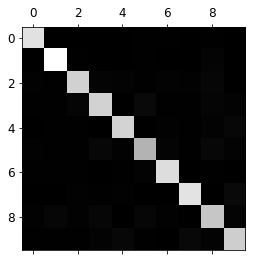

In [62]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_plot", tight_layout=False)
plt.show()

Esta matriz de confusión parece bastante buena, ya que la mayoría de las imágenes están en la diagonal principal, lo que significa que se clasificaron correctamente. Los 5s se ven un poco más oscuros que los otros dígitos, lo que podría significar que hay menos imágenes de 5s en el conjunto de datos o que el clasificador no funciona tan bien en 5s como en otros dígitos. De hecho, podemos verificar que es así en ambos casos. 

Centremos el gráfico en los errores. Primero, dividamos cada valor en la matriz de confusión por el número de imágenes en la clase correspondiente, de modo que pueda comparar los ratios de error en lugar del número absoluto de errores (lo que haría que las clases abundantes se vean injustamente malas):

In [63]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

Ahora llenemos la diagonal con ceros para mantener solo los errores y dibujamos el resultado:

Grabando figura confusion_matrix_errors_plot


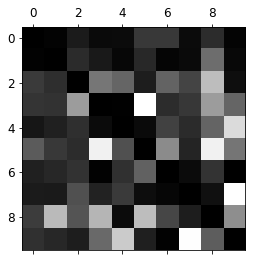

In [64]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_errors_plot", tight_layout=False)
plt.show()

Ahora podemos ver claramente los tipos de errores que comete el clasificador. Recuerdemos que las filas representan clases reales, mientras que las columnas representan clases predichas. Las columnas para las clases 8 y 9 son bastante brillantes, lo que indica que muchas imágenes se clasifican erróneamente como 8 o 9. De manera similar, las filas para las clases 8 y 9 también son bastante brillantes y nos indican que los números 8 y 9 a menudo se confunden con otros dígitos. Por el contrario, algunas filas son bastante oscuras, como la fila 1: esto significa que la mayoría de los 1 se clasifican correctamente (algunos se confunden con las 8, pero eso es todo). Observemos que los errores no son perfectamente simétricos: por ejemplo, hay más 5s clasificados erróneamente como 8s que al revés.

El análisis de la matriz de confusión a menudo nos puede dar ideas sobre cómo mejorar nuestro clasificador. Mirando este gráfico parece que nuestros esfuerzos deberían dedicarse a mejorar la clasificación de 8 y 9, así como a solucionar la confusión específica de 3/5. Por ejemplo, podríamos intentar recopilar más datos de entrenamiento para estos dígitos. O podemos diseñar nuevas funciones que ayuden al clasificador; por ejemplo, escribir un algoritmo para contar el número de bucles cerrados (por ejemplo, 8 tiene dos, 6 tiene uno, 5 no tiene). O podemos preprocesar las imágenes (por ejemplo, utilizando Scikit-Image, Pillow o OpenCV) para hacer que algunos patrones se destaquen más, como los bucles cerrados.

Analizar errores individuales también puede ser una buena forma de obtener información sobre lo que está haciendo su clasificador y por qué está fallando, pero es más difícil y lleva más tiempo. Por ejemplo, vamos a trazar ejemplos de 3 y 5:

Grabando figura error_analysis_digits_plot


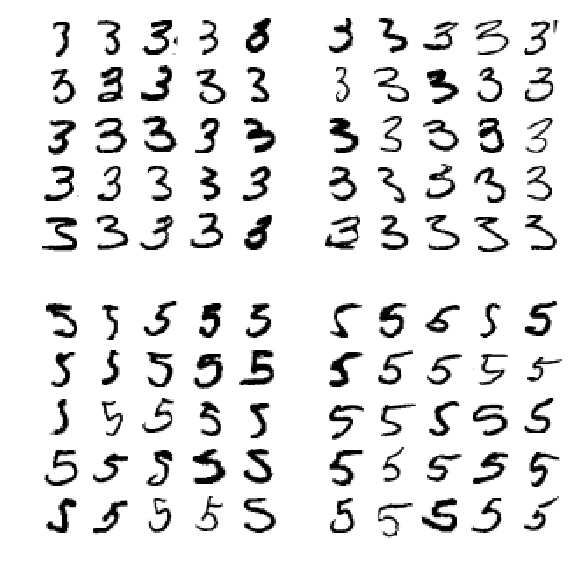

In [65]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
save_fig("error_analysis_digits_plot")
plt.show()

Los dos bloques 5 × 5 de la izquierda muestran los dígitos clasificados como 3 y los dos bloques 5 × 5 de la derecha muestran las imágenes clasificadas como 5s. Algunos de los dígitos en los que el clasificador se equivoca (es decir, en los bloques de abajo a la izquierda y de arriba a la derecha) están tan mal escritos que incluso un humano podría tener problemas para clasificarlos (por ejemplo, el 5 en la 8ª fila y la 1ª columna realmente se ve como un 3). Sin embargo, la mayoría de las imágenes mal clasificadas nos parecen errores obvios y es difícil entender por qué el clasificador cometió los errores que cometió. La razón es que usamos un `SGDClassifier` simple, que es un modelo lineal. Todo lo que hace es asignar un peso por clase a cada píxel y cuando ve una nueva imagen simplemente suma las intensidades de píxeles ponderadas para obtener una puntuación para cada clase. Por lo tanto, como 3s y 5s difieren solo por unos pocos píxeles este modelo los confundirá fácilmente.

La diferencia principal entre 3 y 5 es la posición de la línea pequeña que une la línea superior con el arco inferior. Si dibuja un 3 con la unión ligeramente desplazada hacia la izquierda el clasificador podría clasificarlo como un 5 y viceversa. En otras palabras, este clasificador es bastante sensible al desplazamiento y rotación de la imagen. Por lo tanto, una forma de reducir la confusión 3/5 sería preprocesar las imágenes para garantizar que estén bien centradas y no demasiado rotadas. Esto probablemente ayudará a reducir otros errores también.

# Clasificación Multilabel

Hasta ahora, cada instancia siempre ha sido asignada a una sola clase. En algunos casos, es posible que queramos que nuestro clasificador genere varias clases para cada instancia. Por ejemplo, consideremos un clasificador de reconocimiento facial: ¿qué debería hacer si reconoce a varias personas en la misma imagen? Por supuesto, debe adjuntar una etiqueta por persona que reconoce. Digamos que el clasificador ha sido entrenado para reconocer tres caras, Alice, Bob y Charlie; luego, cuando se muestra una imagen de Alice y Charlie, debe mostrarse [1, 0, 1] (que significa "Alice sí, Bob no, Charlie sí"). Un sistema de clasificación de este tipo que genera múltiples etiquetas binarias se denomina sistema de *clasificación multilabel*.

No vamos a entrar en reconocimiento facial todavía, pero veamos un ejemplo más simple, solo con fines ilustrativos

In [66]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

Este código crea una matriz `y_multilabel` que contiene dos etiquetas objetivo para cada imagen de dígito: la primera indica si el dígito es grande (7, 8 o 9) y la segunda indica si es impar o no. Las siguientes líneas crean una instancia de `KNeighborsClassifier` (que admite la clasificación de varias capas) y la entrenamos utilizando la matriz de múltiples objetivos. Ahora podemos hacer una predicción y comprobar que genera dos etiquetas:

In [67]:
knn_clf.predict([some_digit])

array([[False,  True]])

El dígito 5 no es grande (`False`) y es impar (`True`)

Hay muchas formas de evaluar un clasificador multilabel y seleccionar la métrica correcta realmente depende de nuestro proyecto. Por ejemplo, un enfoque es medir la puntuación de F1 para cada etiqueta individual (o cualquier otra métrica de clasificador binario analizada anteriormente), luego simplemente calcular la puntuacion promedio. Este código calcula el puntaje promedio de F1 en todas las etiquetas:

In [68]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3, n_jobs=-1, verbose=3)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed: 14.5min finished


In [69]:
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.97709078477525

Esto supone que todas las etiquetas son igualmente importantes, lo que puede no ser el caso. En particular, si tenemos muchas más fotos de Alicia que de Bob o Charlie, es posible que deseemos darle más peso a la puntuación del clasificador en las fotografías de Alicia. Una opción simple es dar a cada etiqueta un peso igual a su *support* (es decir, el número de instancias con esa etiqueta objetivo). Para hacer esto, simplemente establecemos `average = "weighted"` en el código anterior.

# Clasificación Multisalida

El último tipo de tarea de clasificación que vamos a discutir aquí se llama *clasificación multioutput-multiclass* (o simplemente *clasificación multioutput*). Es simplemente una generalización de la clasificación multilabel en la que cada etiqueta puede ser multiclase (es decir, puede tener más de dos valores posibles).

Para ilustrar esto, construyamos un sistema que elimine el ruido de las imágenes. Tomará como entrada una imagen de dígitos ruidosos, y (con suerte) emitirá una imagen de dígitos limpios, representada como una matriz de intensidades de píxeles, al igual que las imágenes MNIST. Observemos que la salida del clasificador es multilabel (una etiqueta por píxel) y que cada etiqueta puede tener varios valores (la intensidad de píxeles varía de 0 a 255). Es así un ejemplo de un sistema de clasificación multioutput.

Comencemos creando los conjuntos de entrenamiento y prueba tomando las imágenes del MNIST y agregando ruido a las intensidades de sus píxeles mediante la función `randint()` de NumPy. Las imágenes de destino serán las imágenes originales:

In [70]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

Echemos un vistazo a una imagen del conjunto de prueba (sí, estamos indagando en los datos de la prueba, por lo que deberías estar frunciendo el ceño en este momento):

Grabando figura noisy_digit_example_plot


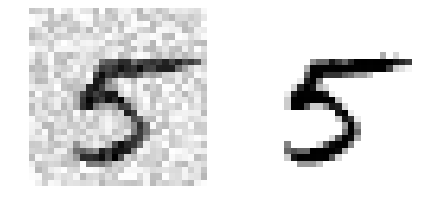

In [71]:
some_index = 5500
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
save_fig("noisy_digit_example_plot")
plt.show()

A la izquierda está la imagen de entrada ruidosa y a la derecha está la imagen de destino limpia. Ahora entrenemos al clasificador y hagamos que limpie esta imagen:

Grabando figura cleaned_digit_example_plot


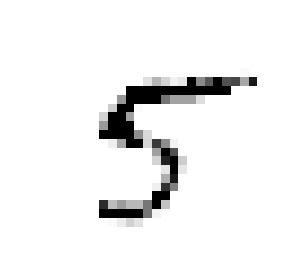

In [72]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)
save_fig("cleaned_digit_example_plot")

¡Se ve lo suficientemente cerca del objetivo! Con esto concluye nuestro recorrido de clasificación. Con suerte, ahora deberíamos saber cómo seleccionar buenas métricas para las tareas de clasificación, elegir el compromiso de precisión / sensibilidad adecuado, comparar clasificadores y, en general, construir buenos sistemas de clasificación para una variedad de tareas.

# Material Extra

## Clasificador dummy

In [73]:
from sklearn.dummy import DummyClassifier

dmy_clf = DummyClassifier()
y_probas_dmy = cross_val_predict(dmy_clf, X_train, y_train_5, cv=3, method="predict_proba")
y_scores_dmy = y_probas_dmy[:, 1]

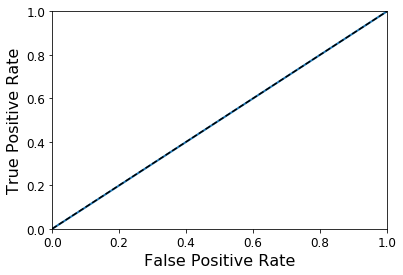

In [74]:
fprr, tprr, thresholdsr = roc_curve(y_train_5, y_scores_dmy)
plot_roc_curve(fprr, tprr)

## Clasificador KNN

In [75]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier(n_jobs=-1, weights='distance', n_neighbors=4)
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=4, p=2,
           weights='distance')

In [76]:
y_knn_pred = knn_clf.predict(X_test)

In [77]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_knn_pred)

0.9714

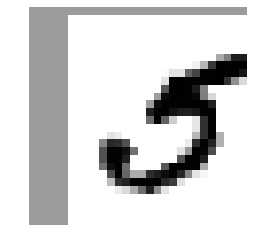

In [78]:
from scipy.ndimage.interpolation import shift

def shift_digit(digit_array, dx, dy, new=0):
    return shift(digit_array.reshape(28, 28), [dy, dx], cval=new).reshape(784)

plot_digit(shift_digit(some_digit, 5, 1, new=100))

In [79]:
X_train_expanded = [X_train]
y_train_expanded = [y_train]
for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    shifted_images = np.apply_along_axis(shift_digit, axis=1, arr=X_train, dx=dx, dy=dy)
    X_train_expanded.append(shifted_images)
    y_train_expanded.append(y_train)

X_train_expanded = np.concatenate(X_train_expanded)
y_train_expanded = np.concatenate(y_train_expanded)
X_train_expanded.shape, y_train_expanded.shape

((300000, 784), (300000,))

In [80]:
knn_clf.fit(X_train_expanded, y_train_expanded)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=4, p=2,
           weights='distance')

In [81]:
y_knn_expanded_pred = knn_clf.predict(X_test)

In [82]:
accuracy_score(y_test, y_knn_expanded_pred)

0.9763

In [83]:
ambiguous_digit = X_test[2589]
knn_clf.predict_proba([ambiguous_digit])

array([[0.       , 0.       , 0.5053645, 0.       , 0.       , 0.       ,
        0.       , 0.4946355, 0.       , 0.       ]])

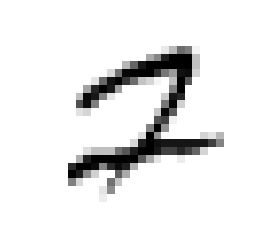

In [84]:
plot_digit(ambiguous_digit)

# Ejercicios

## Ej.1 Un clasificador de MNIST con una precisión de más del 97%

Intenta crear un clasificador para el conjunto de datos MNIST que logre una precisión de más del 97% en el conjunto de prueba. Sugerencia: `KNeighborsClassifier` funciona bastante bien para esta tarea; solo tienes que encontrar buenos valores de hiperparámetros (intente una búsqueda de cuadrícula en los hiperparámetros `weights` y `n_neighbors`).

In [86]:
from sklearn.model_selection import GridSearchCV

param_grid = [{'weights': ["uniform", "distance"], 'n_neighbors': [3, 4, 5]}]

knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=5, verbose=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  30 | elapsed: 139.0min remaining: 277.9min
[Parallel(n_jobs=-1)]: Done  21 out of  30 | elapsed: 259.8min remaining: 111.4min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 260.1min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'weights': ['uniform', 'distance'], 'n_neighbors': [3, 4, 5]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [3]:
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [4]:
grid_search.best_score_

0.97325

In [5]:
from sklearn.metrics import accuracy_score

y_pred = grid_search.predict(X_test)
accuracy_score(y_test, y_pred)

0.9714

## Ej.2 Data Augmentation

Escribe una función que pueda desplazar una imagen MNIST en cualquier dirección (izquierda, derecha, arriba o abajo) en un píxel. Luego, para cada imagen en el conjunto de entrenamiento, crea cuatro copias desplazadas (una por dirección) y añádelas al conjunto de entrenamiento. Finalmente, entrena a tu mejor modelo en este conjunto de entrenamiento ampliado y mide tu precisión en el conjunto de prueba. ¡Debes observar que tu modelo funciona aún mejor ahora! Esta técnica de crecimiento artificial del conjunto de entrenamiento se denomina *data augmentation* o *expansión del conjunto de entrenamiento*.

*Sugerencia*: Puedes usar la función `shift()` del módulo `scipy.ndimage.interpolation`. Por ejemplo, `shift(image, [2, 1], cval = 0)` desplaza la imagen 2 píxeles hacia abajo y 1 píxel hacia la derecha.

In [6]:
from scipy.ndimage.interpolation import shift

In [7]:
def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

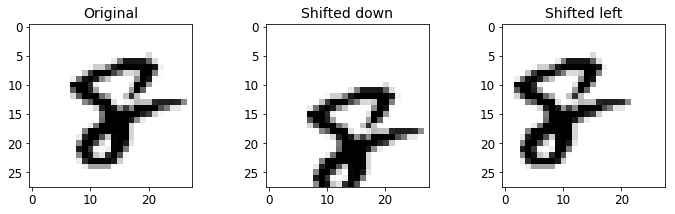

In [8]:
image = X_train[1000]
shifted_image_down = shift_image(image, 0, 5)
shifted_image_left = shift_image(image, -5, 0)

plt.figure(figsize=(12,3))
plt.subplot(131)
plt.title("Original", fontsize=14)
plt.imshow(image.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(132)
plt.title("Shifted down", fontsize=14)
plt.imshow(shifted_image_down.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(133)
plt.title("Shifted left", fontsize=14)
plt.imshow(shifted_image_left.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.show()

In [9]:
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [10]:
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

In [12]:
knn_clf = KNeighborsClassifier(**grid_search.best_params_)

In [13]:
knn_clf.fit(X_train_augmented, y_train_augmented)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=4, p=2,
           weights='distance')

In [14]:
y_pred = knn_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9763

Simplemente aumentando los datos obtuvimos un aumento de precisión de 0.5%.

## Ej.3 Aborda el dataset del Titanic

El objetivo es predecir si un pasajero sobrevivió o no en función de atributos tales como su edad, sexo, clase de pasajero, dónde se embarcaron, etc.

Primero, iniciamos sesión en [Kaggle](https://www.kaggle.com/) y vamos al [desafío del Titanic](https://www.kaggle.com/c/titanic) para descargar `train.csv` y `test.csv`. Los guardamos en el directorio `data/titanic`.

A continuación, vamos a cargar los datos:

In [15]:
import os

TITANIC_PATH = os.path.join("data", "titanic")

In [16]:
import pandas as pd

def load_titanic_data(filename, titanic_path=TITANIC_PATH):
    csv_path = os.path.join(titanic_path, filename)
    return pd.read_csv(csv_path)

In [17]:
train_data = load_titanic_data("train.csv")
test_data = load_titanic_data("test.csv")

Los datos ya están divididos en un conjunto de entrenamiento y un conjunto de prueba. Sin embargo, los datos de prueba *no* contienen las etiquetas: nuestro objetivo es entrenar el mejor modelo posible utilizando los datos de entrenamiento, posteriormente hacer nuestras predicciones sobre los datos de la prueba y subirlos a Kaggle para ver nuestra puntuación final.

Echemos un vistazo a las primeras filas del conjunto de entrenamiento:

In [18]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Los atributos tienen el siguiente significado:

+ **Survived**: este es el objetivo, 0 significa que el pasajero no sobrevivió, mientras que 1 significa que él/ella sobrevivió.
+ **Pclass**: clase del pasajero.
+ **Name, Sex, Age**: auto-explicativo.
+ **SibSp**: cuántos hermanos y cónyuges del pasajero a bordo del Titanic.
+ **Parch**: cuántos hijos y padres del pasajero a bordo del Titanic.
+ **Ticket**: Identificador del ticket.
+ **Fare**: precio pagado (en libras).
+ **Cabin**: número de camarote del pasajero
+ **Embarked**: dónde embarcó el pasajero en el Titanic.

Obtengamos más información para ver cuántos datos faltan:

In [19]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


Bueno, los atributos **Age**, **Cabin** y **Embarked** a veces son nulos (menos de 891 no nulos), especialmente **Cabin** (el 77% son nulos). Ignoraremos **Cabin** por ahora y nos centraremos en el resto. El atributo **Age** tiene alrededor de 19% de valores nulos, por lo que tendremos que decidir qué hacer con ellos. Reemplazar los valores nulos con la edad mediana parece razonable.

Los atributos **Name* y **Ticket** pueden tener algún valor, pero serán un poco difíciles de convertir en números útiles que pueda consumir un modelo. Así que por ahora los ignoraremos.

Echemos un vistazo a los atributos numéricos:

In [20]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


+ ¡Ups! solo el 38% ha sobrevivido (**Survived**). Eso es lo suficientemente cercano al 40%, por lo que la precisión será una métrica razonable para evaluar nuestro modelo.
+ La tarifa media (**Fare**) era de £ 32.20, lo que no parece tan caro (pero probablemente era mucho dinero entonces).
+ La edad media (**Age**) era inferior a 30 años.

Veamos si el objetivo es 0 o 1:

In [21]:
train_data["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

Ahora echemos un vistazo rápido a todos los atributos categóricos:

In [22]:
train_data["Pclass"].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [23]:
train_data["Sex"].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [24]:
train_data["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

El atributo `Embarked` nos dice dónde embarcó el pasajero: C = Cherbourg, Q = Queenstown, S = Southampton.

Ahora vamos a construir nuestras pipelines de preprocesamiento. Reutilizaremos el `DataframeSelector` que creamos en el capítulo anterior para seleccionar atributos específicos del `DataFrame`:

In [25]:
from sklearn.base import BaseEstimator, TransformerMixin

# Clase para seleccionar columnas numéricas o categóricas
# dado que Scikit-Learn no maneja DataFrames
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

Construyamos el pipeline para los atributos numéricos:

In [26]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
        ("select_numeric", DataFrameSelector(["Age", "SibSp", "Parch", "Fare"])),
        ("imputer", SimpleImputer(strategy="median")),
    ])

In [27]:
num_pipeline.fit_transform(train_data)

array([[22.    ,  1.    ,  0.    ,  7.25  ],
       [38.    ,  1.    ,  0.    , 71.2833],
       [26.    ,  0.    ,  0.    ,  7.925 ],
       ...,
       [28.    ,  1.    ,  2.    , 23.45  ],
       [26.    ,  0.    ,  0.    , 30.    ],
       [32.    ,  0.    ,  0.    ,  7.75  ]])

También necesitaremos un `imputer` para las columnas categóricas de texto (el `SimpleImputer` normal no funciona en esas):

In [28]:
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                        index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

In [29]:
from sklearn.preprocessing import OneHotEncoder

In [30]:
cat_pipeline = Pipeline([
        ("select_cat", DataFrameSelector(["Pclass", "Sex", "Embarked"])),
        ("imputer", MostFrequentImputer()),
        ("cat_encoder", OneHotEncoder(sparse=False)),
    ])

In [31]:
cat_pipeline.fit_transform(train_data)

array([[0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 1.],
       ...,
       [0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 1., 0.]])

Por último, unimos los pipelines numérico y categórico:

In [32]:
from sklearn.pipeline import FeatureUnion
preprocess_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

¡Bien! Ahora tenemos un buen pipeline de preprocesamiento que toma los datos sin procesar y genera características de entrada numéricas que podemos incluir en cualquier modelo de aprendizaje automático que queramos.

In [33]:
X_train = preprocess_pipeline.fit_transform(train_data)
X_train

array([[22.,  1.,  0., ...,  0.,  0.,  1.],
       [38.,  1.,  0., ...,  1.,  0.,  0.],
       [26.,  0.,  0., ...,  0.,  0.,  1.],
       ...,
       [28.,  1.,  2., ...,  0.,  0.,  1.],
       [26.,  0.,  0., ...,  1.,  0.,  0.],
       [32.,  0.,  0., ...,  0.,  1.,  0.]])

No olvidemos obtener las etiquetas:

In [34]:
y_train = train_data["Survived"]

Ya estamos listos para entrenar un clasificador. Empecemos con un SVC:

In [35]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto")
svm_clf.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Perfecto, nuestro modelo está entrenado. Usémoslo para realizar predicciones en el conjunto de prueba:

In [36]:
X_test = preprocess_pipeline.transform(test_data)
y_pred = svm_clf.predict(X_test)

Y ahora solo nos queda construir un archivo CSV con estas predicciones (respetando el formato indicado por Kaggle), subirlo y esperar que sea el mejor. ¡Pero espera! Podemos hacer algo mejor que esperar. ¿Por qué no utilizamos la validación cruzada para tener una idea de lo bueno que es nuestro modelo?

In [37]:
from sklearn.model_selection import cross_val_score

svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores.mean()

0.7365250822835092

Bien, más del 73% de precisión, claramente mejor que la posibilidad aleatoria, pero no es una gran puntuación. Mirando la tabla de [clasificación](https://www.kaggle.com/c/titanic/leaderboard) para la competición Titanic en Kaggle, puedes ver que necesitas alcanzar una precisión superior al 80% para estar dentro del top 10% de Kagglers. Algunos alcanzaron el 100%, pero dado que puedes encontrar fácilmente la [lista de víctimas](https://www.encyclopedia-titanica.org/titanic-victims/) del Titanic, ¡parece probable que haya poco machine learning involucrado en su desempeño! ;-) Así que intentemos construir un modelo que alcance el 80% de precisión.

Intentemos un `RandomForestClassifier`:

In [38]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores.mean()

0.8149526160481217

¡Esto está mucho mejor!

En lugar de solo observar la precisión media en los 10 folds de cross-validation, dibujemos las 10 puntuaciones para cada modelo, junto con un diagrama de caja que resalta los cuartiles inferior y superior y los "bigotes" que muestran la extensión de las puntuaciones. Tengamos en cuenta que la función `boxplot()` detecta valores atípicos (llamados "fliers") y no los incluye dentro de los bigotes. Específicamente, si el cuartil inferior es $Q_1$ y el cuartil superior es $Q_3$, entonces el rango intercuartil $IQR = Q_3 - Q_1$ (esta es la altura de la caja) y cualquier puntuación inferior a $Q_1 - 1.5 \times IQR$ es un fliers y también lo es cualquier puntuación superior a $ Q3 + 1.5 \times IQR$.

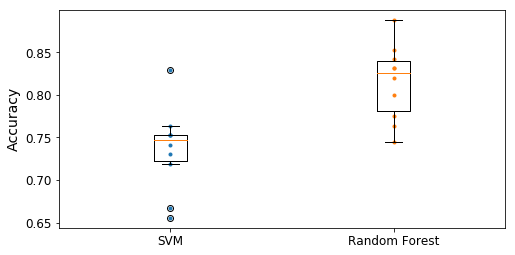

In [39]:
plt.figure(figsize=(8, 4))
plt.plot([1]*10, svm_scores, ".")
plt.plot([2]*10, forest_scores, ".")
plt.boxplot([svm_scores, forest_scores], labels=("SVM","Random Forest"))
plt.ylabel("Accuracy", fontsize=14)
plt.show()

Para mejorar aún más este resultado, podríamos:

+ Comparar muchos más modelos y ajustar los hiperparámetros utilizando la validación cruzada y grid search,
+ Hacer más ingeniería de características, por ejemplo:
 + reemplazar **SibSp** y **Parch** con su suma,
 + intentar identificar partes de nombres que se correlacionan bien con el atributo Survived (por ejemplo, si el nombre contiene "Countess", entonces la supervivencia parece más probable),
 + intentar convertir los atributos numéricos en atributos categóricos: por ejemplo, diferentes grupos de edad tenían tasas de supervivencia muy diferentes (ver más abajo), por lo que puede ayudar a crear una categoría de edad y usarla en lugar de la edad. Del mismo modo, puede ser útil tener una categoría especial para las personas que viajan solas, ya que solo el 30% de ellas sobrevivieron (ver más abajo).

In [40]:
train_data["AgeBucket"] = train_data["Age"] // 15 * 15
train_data[["AgeBucket", "Survived"]].groupby(['AgeBucket']).mean()

,Survived
AgeBucket,
0.0,0.576923
15.0,0.362745
30.0,0.423256
45.0,0.404494
60.0,0.240000
75.0,1.000000


In [41]:
train_data["RelativesOnboard"] = train_data["SibSp"] + train_data["Parch"]
train_data[["RelativesOnboard", "Survived"]].groupby(['RelativesOnboard']).mean()

,Survived
RelativesOnboard,
0,0.303538
1,0.552795
2,0.578431
3,0.724138
4,0.200000
5,0.136364
6,0.333333
7,0.000000
10,0.000000


## Ej.4 Clasificador de spam

Construye un clasificador de spam.

+ Descarga ejemplos de spam de los conjuntos de datos públicos de [Apache SpamAssassin](https://spamassassin.apache.org/old/publiccorpus/).
+ Descomprima los conjuntos de datos y familiarízate con el formato de los datos.
+ Divide los conjuntos de datos en un conjunto de entrenamiento y un conjunto de prueba.
+ Escribe un pipeline de preparación de datos para convertir cada correo electrónico en un vector de características. El proceso de preparación debe transformar un correo electrónico en un vector (disperso) que indique la presencia o ausencia de cada palabra posible. Por ejemplo, si todos los correos electrónicos solo contienen cuatro palabras, "Hello", "how", "are", "you", entonces el correo electrónico "Hello you Hello Hello you" se convertiría en un vector [1, 0, 0 , 1] (significa que ["Hello" está presente, "how" está ausente, "are" está ausente, "you" está presente]) o [3, 0, 0, 2] si prefiere contar el número de apariciones de cada palabra.
+ Es posible que queramos agregar hiperparámetros al pipeline de preparación para controlar si se eliminan o no los encabezados de correo electrónico, convertir cada correo electrónico en minúsculas, eliminar la puntuación, reemplazar todas las URL con "URL", reemplazar todos los números con "NUMBER" o incluso realice *stemming* (es decir, eliminar terminaciones de palabras; hay bibliotecas de Python disponibles para hacer esto).
+ Luego prueba varios clasificadores y mira si puedes crear un gran clasificador de spam, con alta recuperación y alta precisión.

Vamos a obtener los datos:

In [44]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "http://spamassassin.apache.org/old/publiccorpus/"
HAM_URL = DOWNLOAD_ROOT + "20030228_easy_ham.tar.bz2"
SPAM_URL = DOWNLOAD_ROOT + "20030228_spam.tar.bz2"
SPAM_PATH = os.path.join("data", "spam")

def fetch_spam_data(spam_url=SPAM_URL, spam_path=SPAM_PATH):
    if not os.path.isdir(spam_path):
        os.makedirs(spam_path)
    for filename, url in (("ham.tar.bz2", HAM_URL), ("spam.tar.bz2", SPAM_URL)):
        path = os.path.join(spam_path, filename)
        if not os.path.isfile(path):
            urllib.request.urlretrieve(url, path)
        tar_bz2_file = tarfile.open(path)
        tar_bz2_file.extractall(path=SPAM_PATH)
        tar_bz2_file.close()

In [45]:
fetch_spam_data()

Lo siguiente vamos a cargar todos los emails:

In [46]:
HAM_DIR = os.path.join(SPAM_PATH, "easy_ham")
SPAM_DIR = os.path.join(SPAM_PATH, "spam")
ham_filenames = [name for name in sorted(os.listdir(HAM_DIR)) if len(name) > 20]
spam_filenames = [name for name in sorted(os.listdir(SPAM_DIR)) if len(name) > 20]

In [47]:
len(ham_filenames)

2500

In [48]:
len(spam_filenames)

500

Podemos usar el módulo `mail` de Python para analizar estos correos electrónicos (esto maneja los encabezados, la codificación, etc.):

In [49]:
import email
import email.policy

def load_email(is_spam, filename, spam_path=SPAM_PATH):
    directory = "spam" if is_spam else "easy_ham"
    with open(os.path.join(spam_path, directory, filename), "rb") as f:
        return email.parser.BytesParser(policy=email.policy.default).parse(f)

In [50]:
ham_emails = [load_email(is_spam=False, filename=name) for name in ham_filenames]
spam_emails = [load_email(is_spam=True, filename=name) for name in spam_filenames]

Veamos un ejemplo de correo bueno (*ham*) y un ejemplo de spam, para tener una idea de cómo se ven los datos:

In [51]:
print(ham_emails[1].get_content().strip())

Martin A posted:
Tassos Papadopoulos, the Greek sculptor behind the plan, judged that the
 limestone of Mount Kerdylio, 70 miles east of Salonika and not far from the
 Mount Athos monastic community, was ideal for the patriotic sculpture. 
 
 As well as Alexander's granite features, 240 ft high and 170 ft wide, a
 museum, a restored amphitheatre and car park for admiring crowds are
planned
---------------------
So is this mountain limestone or granite?
If it's limestone, it'll weather pretty fast.

------------------------ Yahoo! Groups Sponsor ---------------------~-->
4 DVDs Free +s&p Join Now
http://us.click.yahoo.com/pt6YBB/NXiEAA/mG3HAA/7gSolB/TM
---------------------------------------------------------------------~->

To unsubscribe from this group, send an email to:
forteana-unsubscribe@egroups.com

 

Your use of Yahoo! Groups is subject to http://docs.yahoo.com/info/terms/


In [52]:
print(spam_emails[6].get_content().strip())

Help wanted.  We are a 14 year old fortune 500 company, that is
growing at a tremendous rate.  We are looking for individuals who
want to work from home.

This is an opportunity to make an excellent income.  No experience
is required.  We will train you.

So if you are looking to be employed from home with a career that has
vast opportunities, then go:

http://www.basetel.com/wealthnow

We are looking for energetic and self motivated people.  If that is you
than click on the link and fill out the form, and one of our
employement specialist will contact you.

To be removed from our link simple go to:

http://www.basetel.com/remove.html


4139vOLW7-758DoDY1425FRhM1-764SMFc8513fCsLl40


Algunos correos electrónicos son en realidad multiparte, con imágenes y archivos adjuntos (que pueden tener sus propios archivos adjuntos). Veamos los distintos tipos de estructuras que tenemos:

In [53]:
def get_email_structure(email):
    if isinstance(email, str):
        return email
    payload = email.get_payload()
    if isinstance(payload, list):
        return "multipart({})".format(", ".join([
            get_email_structure(sub_email)
            for sub_email in payload
        ]))
    else:
        return email.get_content_type()

In [54]:
from collections import Counter

def structures_counter(emails):
    structures = Counter()
    for email in emails:
        structure = get_email_structure(email)
        structures[structure] += 1
    return structures

In [55]:
structures_counter(ham_emails).most_common()

[('text/plain', 2408),
 ('multipart(text/plain, application/pgp-signature)', 66),
 ('multipart(text/plain, text/html)', 8),
 ('multipart(text/plain, text/plain)', 4),
 ('multipart(text/plain)', 3),
 ('multipart(text/plain, application/octet-stream)', 2),
 ('multipart(text/plain, text/enriched)', 1),
 ('multipart(text/plain, application/ms-tnef, text/plain)', 1),
 ('multipart(multipart(text/plain, text/plain, text/plain), application/pgp-signature)',
  1),
 ('multipart(text/plain, video/mng)', 1),
 ('multipart(text/plain, multipart(text/plain))', 1),
 ('multipart(text/plain, application/x-pkcs7-signature)', 1),
 ('multipart(text/plain, multipart(text/plain, text/plain), text/rfc822-headers)',
  1),
 ('multipart(text/plain, multipart(text/plain, text/plain), multipart(multipart(text/plain, application/x-pkcs7-signature)))',
  1),
 ('multipart(text/plain, application/x-java-applet)', 1)]

In [56]:
structures_counter(spam_emails).most_common()

[('text/plain', 218),
 ('text/html', 183),
 ('multipart(text/plain, text/html)', 45),
 ('multipart(text/html)', 20),
 ('multipart(text/plain)', 19),
 ('multipart(multipart(text/html))', 5),
 ('multipart(text/plain, image/jpeg)', 3),
 ('multipart(text/html, application/octet-stream)', 2),
 ('multipart(text/plain, application/octet-stream)', 1),
 ('multipart(text/html, text/plain)', 1),
 ('multipart(multipart(text/html), application/octet-stream, image/jpeg)', 1),
 ('multipart(multipart(text/plain, text/html), image/gif)', 1),
 ('multipart/alternative', 1)]

Parece que los emails ham son más a menudo de texto plano, mientras que el spam tiene bastante HTML. Además, muchos emails ham se firman con PGP, mientras que no hay spam. En resumen, parece que la estructura del correo electrónico es información útil a tener en cuenta.

Ahora echemos un vistazo a los encabezados de correo electrónico:

In [57]:
for header, value in spam_emails[0].items():
    print(header,":",value)

Return-Path : <12a1mailbot1@web.de>
Delivered-To : zzzz@localhost.spamassassin.taint.org
Received : from localhost (localhost [127.0.0.1])	by phobos.labs.spamassassin.taint.org (Postfix) with ESMTP id 136B943C32	for <zzzz@localhost>; Thu, 22 Aug 2002 08:17:21 -0400 (EDT)
Received : from mail.webnote.net [193.120.211.219]	by localhost with POP3 (fetchmail-5.9.0)	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 13:17:21 +0100 (IST)
Received : from dd_it7 ([210.97.77.167])	by webnote.net (8.9.3/8.9.3) with ESMTP id NAA04623	for <zzzz@spamassassin.taint.org>; Thu, 22 Aug 2002 13:09:41 +0100
From : 12a1mailbot1@web.de
Received : from r-smtp.korea.com - 203.122.2.197 by dd_it7  with Microsoft SMTPSVC(5.5.1775.675.6);	 Sat, 24 Aug 2002 09:42:10 +0900
To : dcek1a1@netsgo.com
Subject : Life Insurance - Why Pay More?
Date : Wed, 21 Aug 2002 20:31:57 -1600
MIME-Version : 1.0
Message-ID : <0103c1042001882DD_IT7@dd_it7>
Content-Type : text/html; charset="iso-8859-1"
Content-Transfer-Encoding : qu

Probablemente haya mucha información útil aquí, como la dirección de correo electrónico del remitente (12a1mailbot1@web.de parece sospechoso), pero solo nos centraremos en el encabezado `Subject`:

In [59]:
spam_emails[0]["Subject"]

'Life Insurance - Why Pay More?'

Bien, antes de que aprendamos demasiado sobre los datos no olvidemos dividirlos en un conjunto de entrenamiento y un conjunto de prueba:

In [60]:
import numpy as np
from sklearn.model_selection import train_test_split

X = np.array(ham_emails + spam_emails)
y = np.array([0] * len(ham_emails) + [1] * len(spam_emails))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Bien, comencemos a escribir las funciones de preprocesamiento. Primero, necesitaremos una función para convertir HTML a texto plano. Podría decirse que la mejor manera de hacer esto sería usar la gran biblioteca de [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/), pero me gustaría evitar agregar otra dependencia a este proyecto, así que pirateemos una solución rápida y sucia con expresiones regulares (a riesgo de que el [radiactivo no destruya todo el contenido](https://stackoverflow.com/questions/1732348/regex-match-open-tags-except-xhtml-self-contained-tags/1732454#1732454)). La siguiente función primero descarta la sección `<head>`, luego convierte todas las etiquetas `<a>` a la palabra HYPERLINK, luego elimina todas las etiquetas HTML, dejando solo el texto sin formato. Para facilitar la lectura, también reemplaza varias líneas nuevas con líneas nuevas individuales y finalmente elimina las entidades html (como `&gt;` o `&nbsp;`):

In [61]:
import re
from html import unescape

def html_to_plain_text(html):
    text = re.sub('<head.*?>.*?</head>', '', html, flags=re.M | re.S | re.I)
    text = re.sub('<a\s.*?>', ' HYPERLINK ', text, flags=re.M | re.S | re.I)
    text = re.sub('<.*?>', '', text, flags=re.M | re.S)
    text = re.sub(r'(\s*\n)+', '\n', text, flags=re.M | re.S)
    return unescape(text)

Veamos si funciona. Este es HTML spam:

In [62]:
html_spam_emails = [email for email in X_train[y_train==1]
                    if get_email_structure(email) == "text/html"]
sample_html_spam = html_spam_emails[7]
print(sample_html_spam.get_content().strip()[:1000], "...")

<HTML><HEAD><TITLE></TITLE><META http-equiv="Content-Type" content="text/html; charset=windows-1252"><STYLE>A:link {TEX-DECORATION: none}A:active {TEXT-DECORATION: none}A:visited {TEXT-DECORATION: none}A:hover {COLOR: #0033ff; TEXT-DECORATION: underline}</STYLE><META content="MSHTML 6.00.2713.1100" name="GENERATOR"></HEAD>
<BODY text="#000000" vLink="#0033ff" link="#0033ff" bgColor="#CCCC99"><TABLE borderColor="#660000" cellSpacing="0" cellPadding="0" border="0" width="100%"><TR><TD bgColor="#CCCC99" valign="top" colspan="2" height="27">
<font size="6" face="Arial, Helvetica, sans-serif" color="#660000">
<b>OTC</b></font></TD></TR><TR><TD height="2" bgcolor="#6a694f">
<font size="5" face="Times New Roman, Times, serif" color="#FFFFFF">
<b>&nbsp;Newsletter</b></font></TD><TD height="2" bgcolor="#6a694f"><div align="right"><font color="#FFFFFF">
<b>Discover Tomorrow's Winners&nbsp;</b></font></div></TD></TR><TR><TD height="25" colspan="2" bgcolor="#CCCC99"><table width="100%" border="0" 

Y este es resultado en texto plano:

In [63]:
print(html_to_plain_text(sample_html_spam.get_content())[:1000], "...")


OTC
 Newsletter
Discover Tomorrow's Winners 
For Immediate Release
Cal-Bay (Stock Symbol: CBYI)
Watch for analyst "Strong Buy Recommendations" and several advisory newsletters picking CBYI.  CBYI has filed to be traded on the OTCBB, share prices historically INCREASE when companies get listed on this larger trading exchange. CBYI is trading around 25 cents and should skyrocket to $2.66 - $3.25 a share in the near future.
Put CBYI on your watch list, acquire a position TODAY.
REASONS TO INVEST IN CBYI
A profitable company and is on track to beat ALL earnings estimates!
One of the FASTEST growing distributors in environmental & safety equipment instruments.
Excellent management team, several EXCLUSIVE contracts.  IMPRESSIVE client list including the U.S. Air Force, Anheuser-Busch, Chevron Refining and Mitsubishi Heavy Industries, GE-Energy & Environmental Research.
RAPIDLY GROWING INDUSTRY
Industry revenues exceed $900 million, estimates indicate that there could be as much as $25 billi

¡Genial! Ahora escribamos una función que tome un email como entrada y devuelva su contenido como texto plano, sea cual sea su formato:

In [64]:
def email_to_text(email):
    html = None
    for part in email.walk():
        ctype = part.get_content_type()
        if not ctype in ("text/plain", "text/html"):
            continue
        try:
            content = part.get_content()
        except: # in case of encoding issues
            content = str(part.get_payload())
        if ctype == "text/plain":
            return content
        else:
            html = content
    if html:
        return html_to_plain_text(html)

In [65]:
print(email_to_text(sample_html_spam)[:100], "...")


OTC
 Newsletter
Discover Tomorrow's Winners 
For Immediate Release
Cal-Bay (Stock Symbol: CBYI)
Wat ...


¡Vamos lanzarnos a algo de stemming! Para que esto funcione necesitamos instalar Natural Language Toolkit ([NLTK](http://www.nltk.org/)).

In [66]:
import nltk

stemmer = nltk.PorterStemmer()
for word in ("Computations", "Computation", "Computing", "Computed", "Compute", "Compulsive"):
    print(word, "=>", stemmer.stem(word))

Computations => comput
Computation => comput
Computing => comput
Computed => comput
Compute => comput
Compulsive => compuls


También necesitaremos una forma de reemplazar las URL con la palabra "URL". Para esto podríamos usar [expresiones regulares](https://mathiasbynens.be/demo/url-regex) de núcleo duro pero solo usaremos la biblioteca [urlextract](https://github.com/lipoja/URLExtract):

In [68]:
import urlextract

url_extractor = urlextract.URLExtract()
print(url_extractor.find_urls("Will it detect github.com and https://youtu.be/7Pq-S557XQU?t=3m32s"))

['github.com', 'https://youtu.be/7Pq-S557XQU?t=3m32s']


Estamos listos para poner todo esto en un transformador que usaremos para convertir los emails en contadores de palabras. Tenga en cuenta que dividimos oraciones en palabras usando el método `split()` de Python, que usa espacios en blanco para los límites de palabras. Esto funciona para muchos idiomas escritos, pero no para todos. Por ejemplo, los scripts chinos y japoneses generalmente no usan espacios entre palabras y los vietnamitas a menudo usan espacios incluso entre sílabas. Está bien en este ejercicio porque el conjunto de datos está (en su mayoría) en inglés.

In [69]:
from sklearn.base import BaseEstimator, TransformerMixin

class EmailToWordCounterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, strip_headers=True, lower_case=True, remove_punctuation=True,
                 replace_urls=True, replace_numbers=True, stemming=True):
        self.strip_headers = strip_headers
        self.lower_case = lower_case
        self.remove_punctuation = remove_punctuation
        self.replace_urls = replace_urls
        self.replace_numbers = replace_numbers
        self.stemming = stemming
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_transformed = []
        for email in X:
            text = email_to_text(email) or ""
            if self.lower_case:
                text = text.lower()
            if self.replace_urls and url_extractor is not None:
                urls = list(set(url_extractor.find_urls(text)))
                urls.sort(key=lambda url: len(url), reverse=True)
                for url in urls:
                    text = text.replace(url, " URL ")
            if self.replace_numbers:
                text = re.sub(r'\d+(?:\.\d*(?:[eE]\d+))?', 'NUMBER', text)
            if self.remove_punctuation:
                text = re.sub(r'\W+', ' ', text, flags=re.M)
            word_counts = Counter(text.split())
            if self.stemming and stemmer is not None:
                stemmed_word_counts = Counter()
                for word, count in word_counts.items():
                    stemmed_word = stemmer.stem(word)
                    stemmed_word_counts[stemmed_word] += count
                word_counts = stemmed_word_counts
            X_transformed.append(word_counts)
        return np.array(X_transformed)

Vamos a probar este transformador en unos cuantos emails:

In [70]:
X_few = X_train[:3]
X_few_wordcounts = EmailToWordCounterTransformer().fit_transform(X_few)
X_few_wordcounts

array([Counter({'chuck': 1, 'murcko': 1, 'wrote': 1, 'stuff': 1, 'yawn': 1, 'r': 1}),
       Counter({'the': 11, 'of': 9, 'and': 8, 'all': 3, 'christian': 3, 'to': 3, 'by': 3, 'jefferson': 2, 'i': 2, 'have': 2, 'superstit': 2, 'one': 2, 'on': 2, 'been': 2, 'ha': 2, 'half': 2, 'rogueri': 2, 'teach': 2, 'jesu': 2, 'some': 1, 'interest': 1, 'quot': 1, 'url': 1, 'thoma': 1, 'examin': 1, 'known': 1, 'word': 1, 'do': 1, 'not': 1, 'find': 1, 'in': 1, 'our': 1, 'particular': 1, 'redeem': 1, 'featur': 1, 'they': 1, 'are': 1, 'alik': 1, 'found': 1, 'fabl': 1, 'mytholog': 1, 'million': 1, 'innoc': 1, 'men': 1, 'women': 1, 'children': 1, 'sinc': 1, 'introduct': 1, 'burnt': 1, 'tortur': 1, 'fine': 1, 'imprison': 1, 'what': 1, 'effect': 1, 'thi': 1, 'coercion': 1, 'make': 1, 'world': 1, 'fool': 1, 'other': 1, 'hypocrit': 1, 'support': 1, 'error': 1, 'over': 1, 'earth': 1, 'six': 1, 'histor': 1, 'american': 1, 'john': 1, 'e': 1, 'remsburg': 1, 'letter': 1, 'william': 1, 'short': 1, 'again': 1, 'becom

¡Esto se ve bien!

Ahora tenemos los recuentos de palabras y necesitamos convertirlos en vectores. Para esto, construiremos otro transformador cuyo método `fit()` construirá el vocabulario (una lista ordenada de las palabras más comunes) y cuyo método `transform()` usará el vocabulario para convertir los recuentos de palabras en vectores. La salida es una matriz dispersa.

In [71]:
from scipy.sparse import csr_matrix

class WordCounterToVectorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, vocabulary_size=1000):
        self.vocabulary_size = vocabulary_size
    def fit(self, X, y=None):
        total_count = Counter()
        for word_count in X:
            for word, count in word_count.items():
                total_count[word] += min(count, 10)
        most_common = total_count.most_common()[:self.vocabulary_size]
        self.most_common_ = most_common
        self.vocabulary_ = {word: index + 1 for index, (word, count) in enumerate(most_common)}
        return self
    def transform(self, X, y=None):
        rows = []
        cols = []
        data = []
        for row, word_count in enumerate(X):
            for word, count in word_count.items():
                rows.append(row)
                cols.append(self.vocabulary_.get(word, 0))
                data.append(count)
        return csr_matrix((data, (rows, cols)), shape=(len(X), self.vocabulary_size + 1))

In [72]:
vocab_transformer = WordCounterToVectorTransformer(vocabulary_size=10)
X_few_vectors = vocab_transformer.fit_transform(X_few_wordcounts)
X_few_vectors

<3x11 sparse matrix of type '<class 'numpy.int32'>'
	with 20 stored elements in Compressed Sparse Row format>

In [73]:
X_few_vectors.toarray()

array([[ 6,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [99, 11,  9,  8,  1,  3,  3,  1,  3,  2,  3],
       [63,  0,  1,  2,  5,  3,  1,  2,  0,  1,  0]], dtype=int32)

¿Qué significa esta matriz? Bueno, el 99 en la segunda fila, primera columna, significa que el segundo email contiene 99 palabras que no forman parte del vocabulario. El 11 al lado significa que la primera palabra en el vocabulario está presente 11 veces en este correo electrónico. El 9 al lado significa que la segunda palabra está presente 9 veces, y así sucesivamente. Puedes mirar el vocabulario para saber de qué palabras estamos hablando. La primera palabra es "of", la segunda palabra es "and", etc.

In [74]:
vocab_transformer.vocabulary_

{'the': 1,
 'of': 2,
 'and': 3,
 'url': 4,
 'to': 5,
 'all': 6,
 'in': 7,
 'christian': 8,
 'on': 9,
 'by': 10}

¡Ya estamos listos para entrenar a nuestro primer clasificador de spam! Vamos a transformar todo el conjunto de datos:

In [75]:
from sklearn.pipeline import Pipeline

preprocess_pipeline = Pipeline([
    ("email_to_wordcount", EmailToWordCounterTransformer()),
    ("wordcount_to_vector", WordCounterToVectorTransformer()),
])

X_train_transformed = preprocess_pipeline.fit_transform(X_train)

In [77]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

log_clf = LogisticRegression(solver="liblinear", random_state=42)
score = cross_val_score(log_clf, X_train_transformed, y_train, cv=3, verbose=3)
score.mean()

[CV]  ................................................................
[CV] .................................. , score=0.98375, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=0.98375, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=0.99125, total=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished


0.9862500000000001

¡Más del 98.6%, no está mal para un primer intento! Sin embargo, recuerda que estamos utilizando el conjunto de datos "fácil". Puedes probar con los conjuntos de datos más difíciles, los resultados no serán tan sorprendentes. Tendrías que probar varios modelos, seleccionar los mejores y ajustarlos con validación cruzada, y así sucesivamente.

Pero ya tienes una primera impresión, así que paremos ahora, e imprimamos la precisión/sensibilidad que obtuvimos en el conjunto de prueba:

In [80]:
from sklearn.metrics import precision_score, recall_score

X_test_transformed = preprocess_pipeline.transform(X_test)

log_clf = LogisticRegression(solver="liblinear", random_state=42)
log_clf.fit(X_train_transformed, y_train)

y_pred = log_clf.predict(X_test_transformed)

print("Precisión   : {:.2f}%".format(100 * precision_score(y_test, y_pred)))
print("Sensibilidad: {:.2f}%".format(100 * recall_score(y_test, y_pred)))

Precisión   : 94.90%
Sensibilidad: 97.89%


In [84]:
# dill.dump_session("03_classification.env")